In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import get_average_digit_instance_name

from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

import seaborn as sns

Using TensorFlow backend.


## Load input data

In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


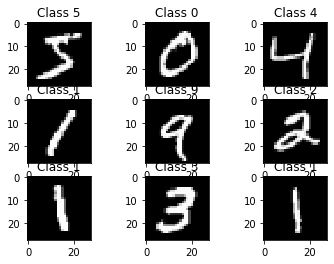

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Prepare data

In [4]:
#prepare correct data shape for Activation Maximization compatibility
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [5]:
all_data = np.append(X_test, X_train, axis=0)
all_onehot_labels = np.append(Y_test, Y_train, axis=0)
all_labels = np.append(y_test, y_train, axis=0)
print(all_data.shape)
print(all_onehot_labels.shape)
print(all_labels.shape)

(70000, 28, 28, 1)
(70000, 10)
(70000,)


## Create neural network

In [6]:
l1_neurons, l2_neurons = 64, 64

In [7]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape, name='conv1'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool'))
model.add(Dropout(0.2))
model.add(Flatten())  # Activation Maximization needs the model to take in structured images, but our NN is fully connected
model.add(Dense(l1_neurons, activation='relu', name='fc1'))
model.add(Dropout(0.2))
model.add(Dense(l2_neurons, activation='relu', name='fc2'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name='predictions'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train network

In [9]:
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4, verbose=1,
          validation_data=(X_test, Y_test))

C:\Users\prokopcerny\.conda\envs\VIZ\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 104us/step - loss: 0.3547 - accuracy: 0.8893 - val_loss: 0.0692 - val_accuracy: 0.9786

### Save model

In [ ]:
model.save("./trained_model")

### Load model

In [ ]:
model = load_model("./trained_model")


In [ ]:
model.predict(X_test[0:1])

In [10]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.03357345678649435
Test accuracy: 0.9896000027656555


In [11]:
# Create selections of a subset of images for each digits and append all missclasifications
digit_to_name = {0: "Zero",
                 1: "One",
                 2: "Two",
                 3: "Three",
                 4: "Four",
                 5: "Five",
                 6: "Six",
                 7: "Seven",
                 8: "Eight",
                 9: "Nine"}

def get_instance_name(digit, num):
    return f'{digit_to_name[digit]} #{num}'

np.random.seed(123)
random_sample_size = 200
selected_data = {}
instance_prediction_results = {get_average_digit_instance_name(digit): {'real': digit, 'pred': digit} for digit in range(10)}

for digit in range(10):
    cur_digit_data = all_data[all_labels == digit]
    # cur_digit_labels = all_labels[all_labels == digit]

    predicted = model.predict_classes(cur_digit_data)

    incorrect_indices = np.nonzero(predicted != digit)[0]
    selected_indices = np.random.choice(cur_digit_data.shape[0], size=(random_sample_size,), replace=False)
    incorrect_unselected = np.fromiter(set(incorrect_indices)-set(selected_indices), dtype=incorrect_indices.dtype)
    all_selected_indices = np.append(selected_indices, incorrect_unselected)
    all_subset = cur_digit_data[all_selected_indices]
    all_subset_preds = predicted[all_selected_indices]
    dimred_mask = np.zeros_like(all_selected_indices, dtype=bool)
    dimred_mask[:random_sample_size] = True
    names = []
    for num, predicted_class in enumerate(all_subset_preds, start=1):
        cur_name = get_instance_name(digit, num)
        names.append(cur_name)
        instance_prediction_results[cur_name] = {'real': digit, 'pred': int(predicted_class)}
    npnames = np.array(names)
    selected_data[digit] = (all_subset, all_subset_preds, npnames, dimred_mask)

    print(f'{incorrect_indices.shape}'
          f' {selected_indices.shape}'
          f' {incorrect_unselected.shape}'
          f' {all_selected_indices.shape}'
          f' {dimred_mask[0]} {dimred_mask[199]} {dimred_mask[200]} {dimred_mask[-1]}'
          f' {np.nonzero(all_subset_preds != digit)[0].shape}')


# np.nonzero(model.predict_classes(all_data) != all_labels)[0].shape

(20,) (200,) (19,) (219,) True True False False (20,)
(44,) (200,) (44,) (244,) True True False False (44,)
(29,) (200,) (29,) (229,) True True False False (29,)
(72,) (200,) (70,) (270,) True True False False (72,)
(41,) (200,) (40,) (240,) True True False False (41,)
(81,) (200,) (78,) (278,) True True False False (81,)
(39,) (200,) (39,) (239,) True True False False (39,)
(66,) (200,) (64,) (264,) True True False False (66,)
(69,) (200,) (65,) (265,) True True False False (69,)
(68,) (200,) (64,) (264,) True True False False (68,)


### Create intermediate layer activations

In [12]:
# fc1_output = Model(inputs=model.input, outputs=model.get_layer(name='fc1').output)
# fc2_output = Model(inputs=model.input, outputs=model.get_layer(name='fc2').output)
# print(fc1_output.predict(X_test[0:1]))
intermediate_dense_outputs = Model(inputs=model.input, outputs=[model.get_layer(name='fc1').output,
                                                          model.get_layer(name='fc2').output,
                                                          model.output])
fc1_t, fc2_t, out_t = map(lambda x: np.average(x, axis=0), intermediate_dense_outputs.predict(X_test[0:2]))


In [13]:
# create average activations for each digit
fc1_activations = {}
fc2_activations = {}
output_activations = {}
for digit in range(10):
    cur_name = get_average_digit_instance_name(digit)
    print(f'\r{cur_name}', end="")
    cur_digit = all_data[all_labels == digit]
    fc1_t, fc2_t, out_t = map(lambda x: np.average(x, axis=0).tolist(), intermediate_dense_outputs.predict(cur_digit))
    fc1_activations[cur_name], fc2_activations[cur_name], output_activations[cur_name] = fc1_t, fc2_t, out_t
print("\nDone")
# print(np.average(fc1_output.predict(all_data[all_labels == 0]), axis=0).shape)

Average 9
Done


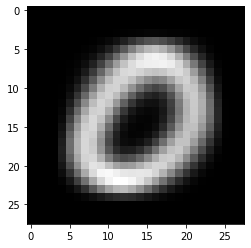

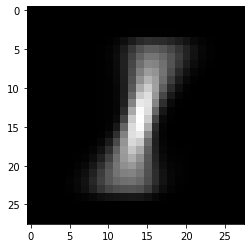

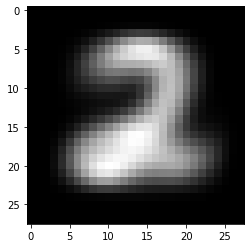

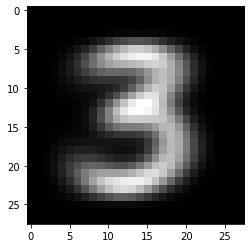

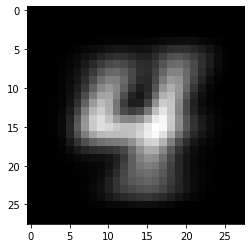

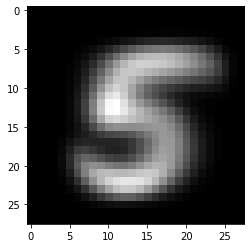

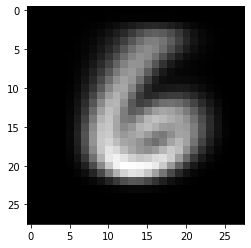

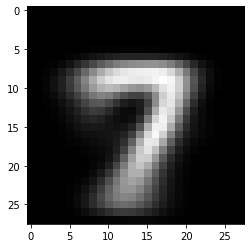

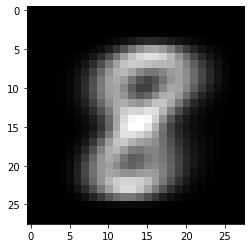

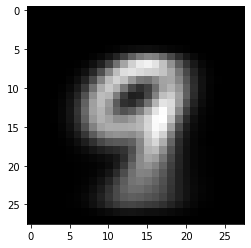

In [14]:
# create images of average digits
images = {}
for digit in range(10):
    cur_name = get_average_digit_instance_name(digit)
    cur_digit = np.average(all_data[all_labels == digit], axis=0).reshape(28,28)
    images[cur_name] = cur_digit.tolist()
    plt.figure()
    plt.imshow(cur_digit, cmap='gray', interpolation='none')

In [15]:
digit_to_instances = {digit:[get_average_digit_instance_name(digit)] for digit in range(10)}

In [16]:
for digit, (cur_images, _, cur_names, cur_dimred_mask) in selected_data.items():
    fc1_t, fc2_t, out_t = intermediate_dense_outputs.predict(cur_images)
    for instance_name, fc1a, fc2a, oa, img in zip(cur_names, fc1_t, fc2_t, out_t, cur_images.reshape(-1, 28, 28)):
        print(f'\r{instance_name}'+10*' ', end="")
        fc1_activations[instance_name] = fc1a.tolist()
        fc2_activations[instance_name] = fc2a.tolist()
        output_activations[instance_name] = oa.tolist()
        images[instance_name] = img.tolist()
        digit_to_instances[digit].append(instance_name)
print('\nDone')

Nine #264           
Done


In [ ]:
a = {0: ("a", 0), 1:("b", 1), 2:("c",2)}
c, d = zip(*a.values())
print(c)
print(d)

### Implementation of principal component analysis

In [17]:
def center(matrix: np.ndarray, axis: int = 0) -> np.ndarray:
    """Centers each feature, such that its mean is 0 and variance is 1

        Parameters
        ----------
        matrix : np.andarray
            Data matrix
        axis : int, optional
            Axis that the method should normalize the data on. 
            By default 0 - assume features are columns

        Returns
        -------
        np.ndarray
            centered data matrix
        """
    centered = matrix - np.mean(matrix, axis=axis)
    standard_dev = centered.std(axis=axis)
    standard_dev = np.where(standard_dev, standard_dev, 1.)
    return centered / standard_dev



def perform_pca(matrix: np.ndarray, variance_explained=0.9, nr_pc=-1) -> np.ndarray:
    """Performs principal component analysis

        Parameters
        ----------
        matrix : np.andarray
            Data matrix to be reduced
        variance_explained : float, optional
            Fraction of variance required to be explained by PCA. PCA then uses minimum number of PCs which satisfies this condition.
            By default 0.9.
        nr_pc : int, optional
            Number of components (dimensions), data should be projected to. 
            By default this parameter is not used

        Returns
        -------
        np.ndarray
            data projected to nr_pc axis
        """
    centered = center(matrix)
    u, s, vh = np.linalg.svd(centered, full_matrices=False)
    if nr_pc >= 1:
        return u[:, :nr_pc] * s[:nr_pc]
    nr_pc = 1
    eigen_val_cumsum = np.cumsum(s ** 2)
    eigen_val_cumsum /= eigen_val_cumsum[-1]
    nr_pc = np.searchsorted(eigen_val_cumsum, variance_explained)
    return u[:, :nr_pc] * s[:nr_pc]


### Separate data for dimensionality reduction
When selecting images, we selected a random sample of 200 images for each digit
as well as all misclassifications for the digit. For scatterplots using dimensionality reduction,
using all of these would result in scatterplots with a skewed distribution, therefore we need to again extract back
the random sample of 200 images, using the dimred mask we created earlier.

In [18]:
# concatenate all selected digit images (and names and labels and mask)
# and then select those for dimensionality reduction using the concatenated dimred mask
*concat_imgs_predictions_names, concat_dimred_mask = (np.concatenate(x, axis=0) for x in zip(*selected_data.values()))
dimred_imgs, dimred_preds, dimred_names = (x[concat_dimred_mask] for x in concat_imgs_predictions_names)
dimred_true_labels = np.repeat(range(10), repeats=random_sample_size)

In [19]:
intermediate_all_outputs = Model(inputs=model.input,
                                 outputs=[model.get_layer(name='conv1').output,
                                          model.get_layer(name='conv2').output,
                                          model.get_layer(name='maxpool').output,
                                          model.get_layer(name='fc1').output,
                                          model.get_layer(name='fc2').output,
                                          model.output])

#### Get all intermediate layer outputs for dimensionality reduction

In [20]:
dimred_conv1, dimred_conv2, dimred_maxpool, dimred_fc1, dimred_fc2, dimred_out = intermediate_all_outputs.predict(dimred_imgs)
dimred_maxpool = dimred_maxpool.reshape(dimred_maxpool.shape[0], -1)  # flatten along unneeded dimensions
dimred_conv1 = dimred_conv1.reshape(dimred_conv1.shape[0], -1)
dimred_conv2 = dimred_conv2.reshape(dimred_conv2.shape[0], -1)

In [21]:
projected_layers = []
for num, layer_data in enumerate([dimred_conv1, dimred_conv2, dimred_maxpool, dimred_fc1, dimred_fc2, dimred_out],
                                 start=1):
    print(f'\rLayer {num}', end="")
    projection = perform_pca(layer_data, nr_pc=2)
    projected_layers.append(projection)
print('\nDone')

proj_conv1, proj_conv2, proj_maxpool, proj_fc1, proj_fc2, proj_out = projected_layers

Layer 6
Done


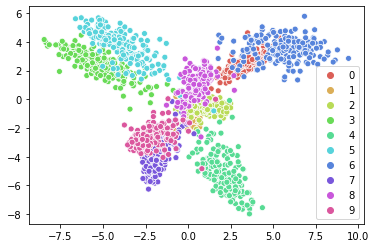

In [22]:
plt.figure()
sns.scatterplot(proj_fc2[:, 0],
                proj_fc2[:, 1],
                hue=dimred_true_labels,
                palette=sns.color_palette("hls", 10),
                legend="full")

In [23]:
conv1_projection = {name:coords.tolist() for name, coords in zip(dimred_names, proj_conv1)}
conv2_projection = {name:coords.tolist() for name, coords in zip(dimred_names, proj_conv2)}
maxpool_projection = {name:coords.tolist() for name, coords in zip(dimred_names, proj_maxpool)}
fc1_projection = {name:coords.tolist() for name, coords in zip(dimred_names, proj_fc1)}
fc2_projection = {name:coords.tolist() for name, coords in zip(dimred_names, proj_fc2)}
out_projection = {name:coords.tolist() for name, coords in zip(dimred_names, proj_out)}
#fc2_projection

In [24]:
projections = {'Convolutional 1': conv1_projection,
               'Convolutional 2': conv2_projection,
               'Maxpool': maxpool_projection,
               'FC1': fc1_projection,
               'FC2': fc2_projection,
               'Output': out_projection}

## Create JSON
As a python dictionary is more or less analogous to JSON objects,
 the schema can be seen by inspecting out_data dictionary

In [25]:
activations = {'FC1': fc1_activations,
               'FC2': fc2_activations,
               'Output': output_activations}

In [26]:
out_data = {'digit_to_instances': digit_to_instances,
            'prediction_results': instance_prediction_results,
            'activations': activations,
            'projections': projections,
            'images': images}

In [ ]:
# saves the first fully connected layer activations to a file
import json
from pathlib import Path
with Path('./NN_data.json').open(mode='w', newline='\n') as file:
    file.write(json.dumps(out_data))
    file.write('\n')

In [27]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

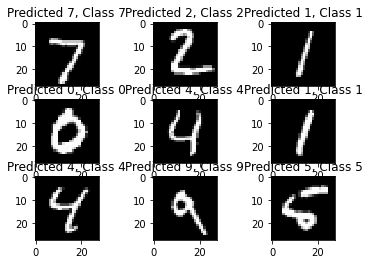

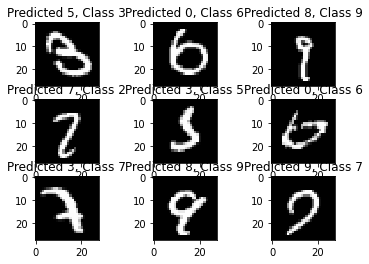

In [28]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

In [ ]:
#ActMax
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

## Visualize max activations for all digits

In [ ]:
for digit in range(10):
    img = visualize_activation(model, layer_idx, filter_indices=digit, input_range=(0., 1.))
    plt.figure()
    plt.imshow(img[..., 0])

## Visualize activation combining multiple digits

In [ ]:
digit_mix = [1,7] # we want to see what the network things is both 1 and 7
img = visualize_activation(model, layer_idx, filter_indices=digit_mix, input_range=(0., 1.))
plt.figure()
plt.imshow(img[..., 0])

